In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import xarray as xr
import theano.tensor as tt
import theano.tensor.nlinalg
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from scipy.stats import multivariate_normal
import numpy as np

In [2]:
pca = PCA(n_components=2)
df = pd.read_csv('../data/all_data.csv')
df = df.drop(columns='transit_stations_percent_change_from_baseline')
df = df.dropna()
X_transformed = pca.fit_transform(df[df.columns[np.r_[1:6]]])
df['component_1'] = X_transformed[:,0]
df['component_2'] = X_transformed[:,1]
df['intercept'] = 1
df['day_of_the_year'] = pd.to_datetime(df['date']).dt.day_of_year

In [3]:
X_depts, y_depts = [], []
time_vecs = []
date_vecs = []
grouped_df =  df.groupby('department_name')
groups = grouped_df.groups.keys()
for n, dept in enumerate(groups):
    df_dept = grouped_df.get_group(dept)
    df_dept = df_dept.sort_values('date')
    date_vecs.append(df_dept['date'])
    X = df_dept[['intercept','component_1','component_2']].to_numpy()
    y = df_dept['incidents'].to_numpy()
    X_depts.append(X)
    y_depts.append(y.flatten())
    df_dept['day_of_the_year'] = pd.to_datetime(df_dept['date']).dt.day_of_year
    time_vecs.append(df_dept['day_of_the_year'].to_numpy())

In [6]:
distance_mats = [distance_matrix(X.reshape(-1,1), X.reshape(-1,1)) for X in time_vecs]

$$
  y_i = f_i + \epsilon
$$

$$
  f_i \sim GP(X_i \beta_i, C_i)
$$

$$
  \beta_{ij} \sim N(\mu_j, \tau_j^2)
$$

In [7]:

def calculate_matern_covariance_function(bandwidth, tau_sq_1, distance, tau_sq_2=1e-6):
    C = tau_sq_1 * np.exp(-1 / 2 * (distance / bandwidth) ** 2) + tau_sq_2 * np.eye(distance.shape[0])
    return C

In [9]:
dept_names = df.department_name.unique()

with pm.Model() as hierarchical_model:
    mu_beta_0 = pm.Normal("mu_beta_0", mu=0.0, sigma=10)
    sigma_squared_beta_0 = pm.InverseGamma('sigma_squared_beta_0',alpha=0.5, beta=0.5)
    
    mu_beta_1 = pm.Normal("mu_beta_1", mu=0.0, sigma=10)
    sigma_squared_beta_1 = pm.InverseGamma('sigma_squared_beta_1',alpha=0.5, beta=0.5)
    
    mu_beta_2 = pm.Normal("mu_beta_2", mu=0.0, sigma=10)
    sigma_squared_beta_2 = pm.InverseGamma('sigma_squared_beta_2',alpha=0.5, beta=0.5)
    
    beta_0 = pm.Normal("beta_0", mu=mu_beta_0, sigma=np.sqrt(sigma_squared_beta_0), shape=len(X_depts))
    beta_1 = pm.Normal("beta_1", mu=mu_beta_1, sigma=np.sqrt(sigma_squared_beta_1), shape=len(X_depts))
    beta_2 = pm.Normal("beta_2", mu=mu_beta_2, sigma=np.sqrt(sigma_squared_beta_2), shape=len(X_depts))
    
    bandwidth = pm.Uniform('b', lower=1, upper=30 ,shape=len(X_depts))
    tau_s1 =  pm.Uniform('tau_sq', lower=1, upper=100, shape=len(X_depts))
    
    C = [calculate_matern_covariance_function(bandwidth[i], tau_s1[i], distance_mats[i], tau_sq_2=1e-6) for i in range(len(np.unique(dept_idxs)))]    
    means = [beta_0[i] + beta_1[i] * X_depts[i][:, 1] + beta_2[i] * X_depts[i][:, 2] for i in range(len(X_depts))]
    
    #f = [pm.MvNormal(f'f{i}', mu=means[i], cov=C[i], shape=X_depts[i].shape[0]) for i in range(len(X_depts))]
    
    #eps = pm.Uniform("eps", lower=0.0, upper=10000, shape=len(X_depts))

    data_like = [pm.MvNormal(
        f"data_like{i}", mu=means[i], cov=C[i], observed=y_depts[i]) for i in range(len(X_depts))]
    
with hierarchical_model:
    hierarchical_trace = pm.sample(500, tune=500, target_accept=0.9, chains=1)
    
    

/Users/juliette/opt/anaconda3/envs/reseach_env/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tau_sq, b, beta_2, beta_1, beta_0, sigma_squared_beta_2, mu_beta_2, sigma_squared_beta_1, mu_beta_1, sigma_squared_beta_0, mu_beta_0]


/Users/juliette/opt/anaconda3/envs/reseach_env/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/envs/reseach_env/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `tau_sq_interval__`.ravel()[0] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[1] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[2] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[3] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[4] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[5] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[6] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[7] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[8] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[9] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[10] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[11] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[12] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[13] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[14] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[15] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[16] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[17] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[18] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[19] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[20] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[21] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[22] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[23] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[24] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[25] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[26] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[27] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[28] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[29] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[30] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[31] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[32] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[33] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[34] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[35] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[36] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[37] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[38] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[39] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[40] is zero.
The derivative of RV `tau_sq_interval__`.ravel()[41] is zero.
The derivative of RV `b_interval__`.ravel()[0] is zero.
The derivative of RV `b_interval__`.ravel()[1] is zero.
The derivative of RV `b_interval__`.ravel()[3] is zero.
The derivative of RV `b_interval__`.ravel()[5] is zero.
The derivative of RV `b_interval__`.ravel()[6] is zero.
The derivative of RV `b_interval__`.ravel()[7] is zero.
The derivative of RV `b_interval__`.ravel()[8] is zero.
The derivative of RV `b_interval__`.ravel()[9] is zero.
The derivative of RV `b_interval__`.ravel()[10] is zero.
The derivative of RV `b_interval__`.ravel()[11] is zero.
The derivative of RV `b_interval__`.ravel()[12] is zero.
The derivative of RV `b_interval__`.ravel()[13] is zero.
The derivative of RV `b_interval__`.ravel()[14] is zero.
The derivative of RV `b_interval__`.ravel()[15] is zero.
The derivative of RV `b_interval__`.ravel()[16] is zero.
The derivative of RV `b_interval__`.ravel()[17] is zero.
The derivative of RV `b_interval__`.ravel()[18] is zero.
The derivative of RV `b_interval__`.ravel()[19] is zero.
The derivative of RV `b_interval__`.ravel()[20] is zero.
The derivative of RV `b_interval__`.ravel()[21] is zero.
The derivative of RV `b_interval__`.ravel()[23] is zero.
The derivative of RV `b_interval__`.ravel()[24] is zero.
The derivative of RV `b_interval__`.ravel()[25] is zero.
The derivative of RV `b_interval__`.ravel()[26] is zero.
The derivative of RV `b_interval__`.ravel()[27] is zero.
The derivative of RV `b_interval__`.ravel()[28] is zero.
The derivative of RV `b_interval__`.ravel()[29] is zero.
The derivative of RV `b_interval__`.ravel()[30] is zero.
The derivative of RV `b_interval__`.ravel()[31] is zero.
The derivative of RV `b_interval__`.ravel()[33] is zero.
The derivative of RV `b_interval__`.ravel()[34] is zero.
The derivative of RV `b_interval__`.ravel()[35] is zero.
The derivative of RV `b_interval__`.ravel()[36] is zero.
The derivative of RV `b_interval__`.ravel()[37] is zero.
The derivative of RV `b_interval__`.ravel()[38] is zero.
The derivative of RV `b_interval__`.ravel()[39] is zero.
The derivative of RV `b_interval__`.ravel()[40] is zero.
The derivative of RV `b_interval__`.ravel()[41] is zero.
The derivative of RV `beta_2`.ravel()[0] is zero.
The derivative of RV `beta_2`.ravel()[1] is zero.
The derivative of RV `beta_2`.ravel()[2] is zero.
The derivative of RV `beta_2`.ravel()[3] is zero.
The derivative of RV `beta_2`.ravel()[4] is zero.
The derivative of RV `beta_2`.ravel()[5] is zero.
The derivative of RV `beta_2`.ravel()[6] is zero.
The derivative of RV `beta_2`.ravel()[7] is zero.
The derivative of RV `beta_2`.ravel()[8] is zero.
The derivative of RV `beta_2`.ravel()[9] is zero.
The derivative of RV `beta_2`.ravel()[10] is zero.
The derivative of RV `beta_2`.ravel()[11] is zero.
The derivative of RV `beta_2`.ravel()[12] is zero.
The derivative of RV `beta_2`.ravel()[13] is zero.
The derivative of RV `beta_2`.ravel()[14] is zero.
The derivative of RV `beta_2`.ravel()[15] is zero.
The derivative of RV `beta_2`.ravel()[16] is zero.
The derivative of RV `beta_2`.ravel()[17] is zero.
The derivative of RV `beta_2`.ravel()[18] is zero.
The derivative of RV `beta_2`.ravel()[19] is zero.
The derivative of RV `beta_2`.ravel()[20] is zero.
The derivative of RV `beta_2`.ravel()[21] is zero.
The derivative of RV `beta_2`.ravel()[22] is zero.
The derivative of RV `beta_2`.ravel()[23] is zero.
The derivative of RV `beta_2`.ravel()[24] is zero.
The derivative of RV `beta_2`.ravel()[25] is zero.
The derivative of RV `beta_2`.ravel()[26] is zero.
The derivative of RV `beta_2`.ravel()[27] is zero.
The derivative of RV `beta_2`.ravel()[28] is zero.
The derivative of RV `beta_2`.ravel()[29] is zero.
The derivative of RV `beta_2`.ravel()[30] is zero.
The derivative of RV `beta_2`.ravel()[31] is zero.
The derivative of RV `beta_2`.ravel()[32] is zero.
The derivative of RV `beta_2`.ravel()[33] is zero.
The derivative of RV `beta_2`.ravel()[34] is zero.
The derivative of RV `beta_2`.ravel()[35] is zero.
The derivative of RV `beta_2`.ravel()[36] is zero.
The derivative of RV `beta_2`.ravel()[37] is zero.
The derivative of RV `beta_2`.ravel()[38] is zero.
The derivative of RV `beta_2`.ravel()[39] is zero.
The derivative of RV `beta_2`.ravel()[40] is zero.
The derivative of RV `beta_2`.ravel()[41] is zero.
The derivative of RV `beta_1`.ravel()[0] is zero.
The derivative of RV `beta_1`.ravel()[1] is zero.
The derivative of RV `beta_1`.ravel()[2] is zero.
The derivative of RV `beta_1`.ravel()[3] is zero.
The derivative of RV `beta_1`.ravel()[4] is zero.
The derivative of RV `beta_1`.ravel()[5] is zero.
The derivative of RV `beta_1`.ravel()[6] is zero.
The derivative of RV `beta_1`.ravel()[7] is zero.
The derivative of RV `beta_1`.ravel()[8] is zero.
The derivative of RV `beta_1`.ravel()[9] is zero.
The derivative of RV `beta_1`.ravel()[10] is zero.
The derivative of RV `beta_1`.ravel()[11] is zero.
The derivative of RV `beta_1`.ravel()[12] is zero.
The derivative of RV `beta_1`.ravel()[13] is zero.
The derivative of RV `beta_1`.ravel()[14] is zero.
The derivative of RV `beta_1`.ravel()[15] is zero.
The derivative of RV `beta_1`.ravel()[16] is zero.
The derivative of RV `beta_1`.ravel()[17] is zero.
The derivative of RV `beta_1`.ravel()[18] is zero.
The derivative of RV `beta_1`.ravel()[19] is zero.
The derivative of RV `beta_1`.ravel()[20] is zero.
The derivative of RV `beta_1`.ravel()[21] is zero.
The derivative of RV `beta_1`.ravel()[22] is zero.
The derivative of RV `beta_1`.ravel()[23] is zero.
The derivative of RV `beta_1`.ravel()[24] is zero.
The derivative of RV `beta_1`.ravel()[25] is zero.
The derivative of RV `beta_1`.ravel()[26] is zero.
The derivative of RV `beta_1`.ravel()[27] is zero.
The derivative of RV `beta_1`.ravel()[28] is zero.
The derivative of RV `beta_1`.ravel()[29] is zero.
The derivative of RV `beta_1`.ravel()[30] is zero.
The derivative of RV `beta_1`.ravel()[31] is zero.
The derivative of RV `beta_1`.ravel()[32] is zero.
The derivative of RV `beta_1`.ravel()[33] is zero.
The derivative of RV `beta_1`.ravel()[34] is zero.
The derivative of RV `beta_1`.ravel()[35] is zero.
The derivative of RV `beta_1`.ravel()[36] is zero.
The derivative of RV `beta_1`.ravel()[37] is zero.
The derivative of RV `beta_1`.ravel()[38] is zero.
The derivative of RV `beta_1`.ravel()[39] is zero.
The derivative of RV `beta_1`.ravel()[40] is zero.
The derivative of RV `beta_1`.ravel()[41] is zero.
The derivative of RV `beta_0`.ravel()[0] is zero.
The derivative of RV `beta_0`.ravel()[1] is zero.
The derivative of RV `beta_0`.ravel()[2] is zero.
The derivative of RV `beta_0`.ravel()[3] is zero.
The derivative of RV `beta_0`.ravel()[4] is zero.
The derivative of RV `beta_0`.ravel()[5] is zero.
The derivative of RV `beta_0`.ravel()[6] is zero.
The derivative of RV `beta_0`.ravel()[7] is zero.
The derivative of RV `beta_0`.ravel()[8] is zero.
The derivative of RV `beta_0`.ravel()[9] is zero.
The derivative of RV `beta_0`.ravel()[10] is zero.
The derivative of RV `beta_0`.ravel()[11] is zero.
The derivative of RV `beta_0`.ravel()[12] is zero.
The derivative of RV `beta_0`.ravel()[13] is zero.
The derivative of RV `beta_0`.ravel()[14] is zero.
The derivative of RV `beta_0`.ravel()[15] is zero.
The derivative of RV `beta_0`.ravel()[16] is zero.
The derivative of RV `beta_0`.ravel()[17] is zero.
The derivative of RV `beta_0`.ravel()[18] is zero.
The derivative of RV `beta_0`.ravel()[19] is zero.
The derivative of RV `beta_0`.ravel()[20] is zero.
The derivative of RV `beta_0`.ravel()[22] is zero.
The derivative of RV `beta_0`.ravel()[23] is zero.
The derivative of RV `beta_0`.ravel()[24] is zero.
The derivative of RV `beta_0`.ravel()[25] is zero.
The derivative of RV `beta_0`.ravel()[26] is zero.
The derivative of RV `beta_0`.ravel()[27] is zero.
The derivative of RV `beta_0`.ravel()[28] is zero.
The derivative of RV `beta_0`.ravel()[29] is zero.
The derivative of RV `beta_0`.ravel()[30] is zero.
The derivative of RV `beta_0`.ravel()[31] is zero.
The derivative of RV `beta_0`.ravel()[32] is zero.
The derivative of RV `beta_0`.ravel()[33] is zero.
The derivative of RV `beta_0`.ravel()[34] is zero.
The derivative of RV `beta_0`.ravel()[35] is zero.
The derivative of RV `beta_0`.ravel()[36] is zero.
The derivative of RV `beta_0`.ravel()[37] is zero.
The derivative of RV `beta_0`.ravel()[38] is zero.
The derivative of RV `beta_0`.ravel()[39] is zero.
The derivative of RV `beta_0`.ravel()[40] is zero.
The derivative of RV `beta_0`.ravel()[41] is zero.
The derivative of RV `sigma_squared_beta_2_log__`.ravel()[0] is zero.
The derivative of RV `mu_beta_2`.ravel()[0] is zero.
The derivative of RV `sigma_squared_beta_1_log__`.ravel()[0] is zero.
The derivative of RV `mu_beta_1`.ravel()[0] is zero.
The derivative of RV `sigma_squared_beta_0_log__`.ravel()[0] is zero.
The derivative of RV `mu_beta_0`.ravel()[0] is zero.

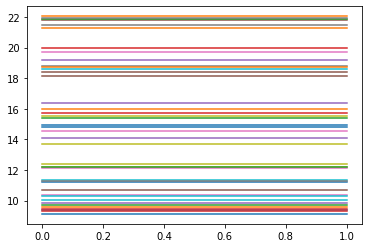

In [216]:
plt.plot(hierarchical_trace.get_values('b'));

In [185]:
distance_mats[2].shape


(39, 39)

In [156]:
type(theano.shared(C))

theano.compile.sharedvalue.SharedVariable

In [ ]:
az.plot_trace(hierarchical_trace, var_names=['mu_beta_1', 'mu_beta_0','eps']);

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


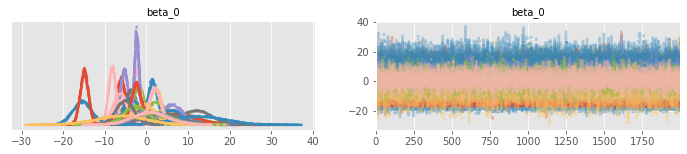

In [6]:
az.plot_trace(hierarchical_trace, var_names=["beta_0"], coords={"dept": dept_names});

In [7]:
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())
X_depts, y_depts = [], []
pca = PCA(n_components=2)
time_vecs = []
date_vecs = []
for n, dept in enumerate(groups):
    df_dept = grouped_df.get_group(dept)
    df_dept = df_dept.sort_values('date')
    date_vecs.append(df_dept['date'])
    X = df_dept[['intercept','component_1','component_2']].to_numpy()
    y = df_dept['incidents'].to_numpy()
    X_depts.append(X)
    y_depts.append(y.flatten())
    df_dept['day_of_the_year'] = pd.to_datetime(df_dept['date']).dt.day_of_year
    time_vecs.append(df_dept['day_of_the_year'].to_numpy())

gb = basic_gibbs.GibbsSampler(X_depts, y_depts, n_iter=5000, burn=1000)
gb.fit()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:09<00:00, 72.17it/s]


In [8]:
betas_ols = np.zeros([42, 3])
for n, dept in enumerate(groups):
    X, y = X_depts[n][:,1:], y_depts[n]
    reg = LinearRegression()
    reg.fit(X, y)
    betas_ols[n, :] = np.vstack([reg.intercept_,reg.coef_.reshape(-1,1)]).flatten()

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_94367/4186075826.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


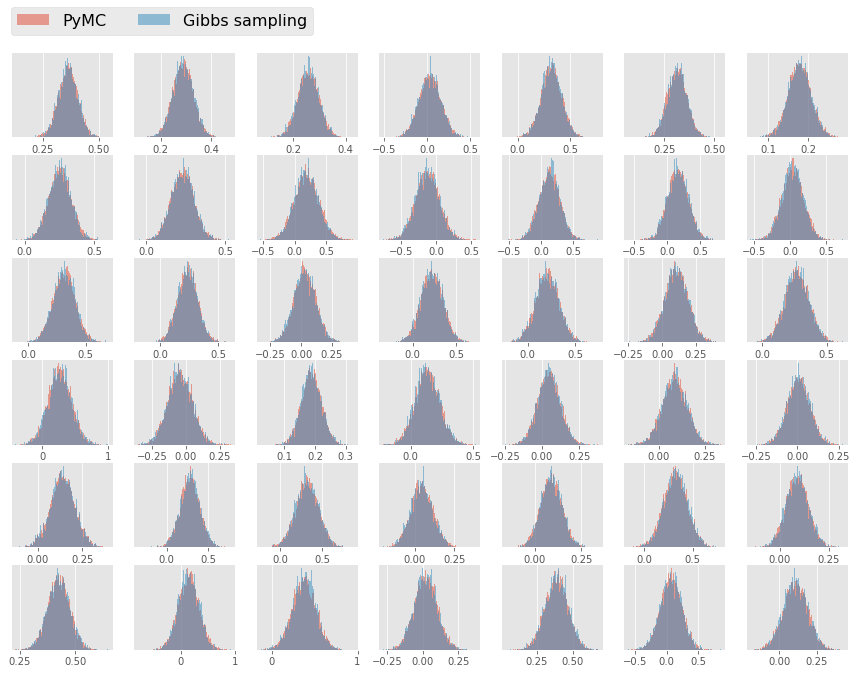

In [9]:
plt.figure(figsize=(15,11))
for i in range(len(groups)):
    plt.subplot(6,7,i+1)
    plt.hist(hierarchical_trace.get_values('beta_2')[:,i], density=True,  bins=100, alpha=.5, label='PyMC')
    plt.hist(gb.traces['betas'][:,2,i], density=True,  bins=100, alpha=.5, label='Gibbs sampling')
    plt.yticks([])
    plt.xticks(fontsize=10)
   # plt.axvline(x=betas_ols[i,1])
    
    if i == 0:
        plt.legend(loc=(0,1.2), ncol=2)
plt.tight_layout()
plt.savefig('../writeup/compare_gibbs_pymc2.png', dpi=300, bbox_inches='tight')

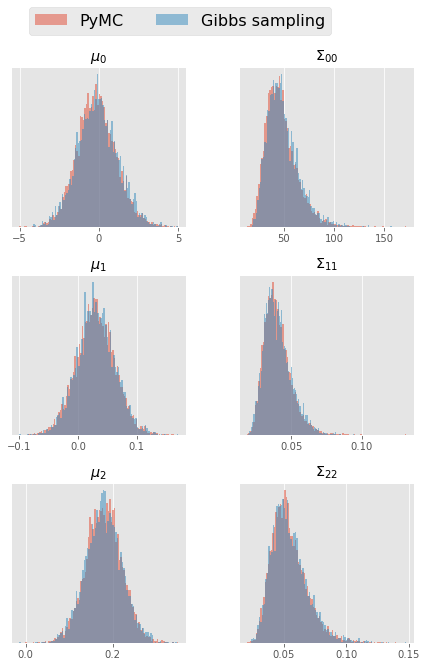

In [10]:
plt.figure(figsize=(7,10))
for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist(hierarchical_trace.get_values(f'mu_beta_{i}'), density=True,  bins=100, alpha=.5)
    plt.hist(gb.traces['mu'][:,i], density=True,  bins=100, alpha=.5)
    plt.xticks(fontsize=10)
    plt.yticks([])
    string = str(i) + str(i)
    plt.title(fr'$\mu_{i}$')
    plt.subplot(3,2,2*i+2)
    plt.hist(hierarchical_trace.get_values(f'sigma_squared_beta_{i}'), density=True,  bins=100, alpha=.5, label='PyMC')
    plt.hist(gb.traces['sigmas_diag'][:,i], density=True,  bins=100, alpha=.5, label='Gibbs sampling')
    if i ==0:
        plt.legend(loc=(-1.2,1.2), ncol=2)
    plt.xticks(fontsize=10)
    plt.yticks([])
    tot_string = ('$\Sigma_' + '{' + string + '}$')
    plt.title(tot_string)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.savefig('../writeup/compare_gibbs_pymc1.png', dpi=300, bbox_inches='tight')
    

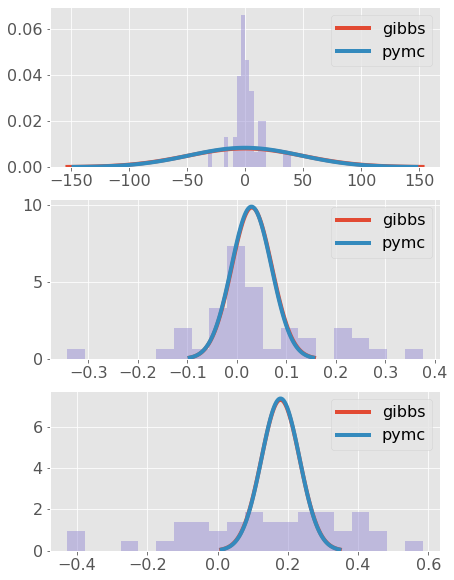

In [11]:
plt.figure(figsize=(7,10))
means_g = gb.traces['mu'].mean(axis=0)
diag_cov_g = gb.traces['sigmas_diag'].mean(axis=0)
means_p = [hierarchical_trace.get_values(f'mu_beta_{i}').mean() for i in range(3)]
diag_cov_p = [hierarchical_trace.get_values(f'sigma_squared_beta_{i}').mean() for i in range(3)]


from scipy.stats import norm
for i in range(3):
    plt.subplot(3,1,i+1)
    dist = norm(loc=means_g[i], scale=diag_cov_g[i])
    x = np.linspace(dist.ppf(0.001),dist.ppf(0.999),100)
    plt.plot(x, dist.pdf(x), label='gibbs')
    
    dist = norm(loc=means_p[i], scale=diag_cov_p[i])
    x = np.linspace(dist.ppf(0.001),dist.ppf(0.999),100)
    plt.plot(x, dist.pdf(x), label='pymc')
    plt.hist(betas_ols[:, i], alpha=.5, bins=20,density=True)
    plt.legend()